# 2차 EDA

#### Faster R-CNN 학습 결과에 대한 BBox에 분석

In [18]:
import os
import re
import json
import platform
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from tqdm import tqdm
from tabulate import tabulate

from PIL import Image
from collections import Counter, defaultdict
from pycocotools.coco import COCO

from font_downloader import set_nanumgothic_font
from bbox_counter import load_bbox_performance, parse_val_analysis, fill_data_from_performance, parse_log_stats


os_name = platform.system()

if os_name == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
    root = 'C:/Users/yeyec/workspace/server2'
else:
    # font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    # for font in font_list:
    #     print(fm.FontProperties(fname=font).get_name())

    font_path = set_nanumgothic_font()
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = 'NanumGothic'
    root = '/data/ephemeral/home'


source = root + '/dataset/train.json'
image_dir  = root + '/dataset/train'


with open(source, 'r') as file:
    data = json.load(file)

# 클래스 컬러 설정
class_colors = { 
    0: (1, 101, 132),    # General trash
    1: (244, 165, 127),  # Paper
    2: (247, 225, 168),  # Paper pack
    3: (3, 137, 153),    # Metal
    4: (138, 204, 165),  # Glass
    5: (210, 231, 174),  # Plastic
    6: (245, 195, 141),  # Styrofoam
    7: (66, 173, 162),   # Plastic bag
    8: (226, 100, 133),  # Battery
    9: (239, 132, 126)   # Clothing
}

color3 = [(251, 230, 190), (255, 167, 71), (0, 166, 255)]
color3_1 = [(245, 195, 141), (254, 114, 53), (0, 119, 255)]

normalized_class_colors = {class_id: (r/255, g/255, b/255) for class_id, (r, g, b) in class_colors.items()}

In [19]:
if 'categories' in data:
    categories = data['categories']
    id_to_name = {category['id']: category['name'] for category in categories}

    categories_id_name = {cat['id']: cat['name'] for cat in categories}
    

if 'annotations' in data:
    annotations = data['annotations']


if 'images' in data:
    images = data['images']
    images_id_img = {img['id']: img for img in data['images']}


num_images = len(images)
num_annotations = len(annotations)
num_categories = len(categories)

#### 전체 데이터 개수

In [20]:
print(f"학습 이미지 수: {num_images}")
print(f"BBox 수: {num_annotations}")
print(f"클래스 수: {num_categories}")

학습 이미지 수: 4883
BBox 수: 23144
클래스 수: 10


#### 카테고리별 바운딩 박스 수

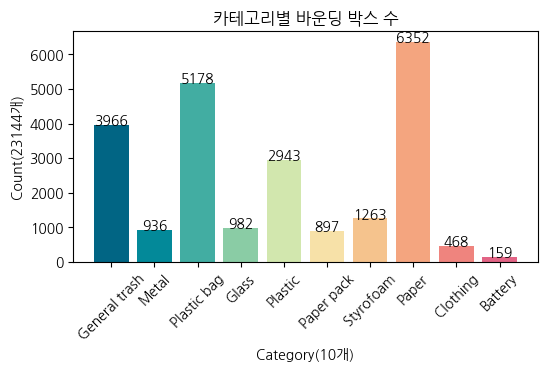

In [21]:
if 'annotations' in data:
    category_ids = [item['category_id'] for item in annotations]
    category_id_count = Counter(category_ids)
    
    category_count = list(category_id_count.keys())
    counts = list(category_id_count.values())

    colors = [normalized_class_colors[cat_id] for cat_id in category_count]
    category_names = [id_to_name[cat_id] for cat_id in category_count]

    plt.figure(figsize=(6, 3))
    bars = plt.bar(category_names, counts, color=colors)
    plt.xlabel(f'Category({num_categories}개)')
    plt.ylabel(f'Count({num_annotations}개)')
    plt.title('카테고리별 바운딩 박스 수')
    plt.xticks(rotation=45)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center')

    
    plt.show()

### 바운딩 박스 크기에 대한 분석

#### 임계값 정의 (S: 32^2 이하, M: 32^2 ~ 96^2, L: 96^2 이상)

In [22]:
small_threshold = 32 ** 2
medium_threshold = 96 ** 2

size_categories = []

for annotation in annotations:
    bbox = annotation['bbox']
    width, height = bbox[2], bbox[3]
    area = width * height
    
    if area <= small_threshold:
        size_categories.append('S')
    elif small_threshold < area <= medium_threshold:
        size_categories.append('M')
    else:
        size_categories.append('L')

size_count = Counter(size_categories)

#### BBox 면적 크기별 개수

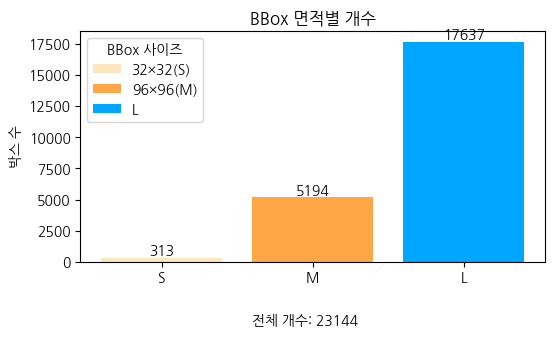

Size L: 17637개(76.0%)
Size M: 5194개(22.0%)
Size S: 313개(1.0%)
총 bbox 개수: 23144개


In [23]:
plt.figure(figsize=(6, 3))
size_keys_reversed = list(size_count.keys())[::-1]
size_values_reversed = list(size_count.values())[::-1]

bars = plt.bar(size_keys_reversed, size_values_reversed, color=[(r/255, g/255, b/255) for r, g, b in color3], label=['32×32(S)', '96×96(M)', 'L'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.figtext(0.5, -0.1, f'전체 개수: {num_annotations}', ha='center', fontsize=10)

plt.legend(title="BBox 사이즈")

plt.ylabel('박스 수')
plt.title('BBox 면적별 개수')
plt.show()

for size, count in size_count.items():
    print(f"Size {size}: {count}개({count/num_annotations *10000 // 100}%)")
print(f"총 bbox 개수: {num_annotations}개")

#### 클래스별 bbox 개수

In [24]:
class_size_count = defaultdict(lambda: {'S': 0, 'M': 0, 'L': 0})

for annotation in annotations:
    bbox = annotation['bbox']
    class_id = annotation['category_id']
    width, height = bbox[2], bbox[3]
    area = width * height
    
    # 크기 카테고리에 따라 S, M, L 분류
    if area <= small_threshold:
        class_size_count[class_id]['S'] += 1
    elif small_threshold < area <= medium_threshold:
        class_size_count[class_id]['M'] += 1
    else:
        class_size_count[class_id]['L'] += 1


classes = list(class_size_count.keys())
S_count = [class_size_count[cls]['S'] for cls in classes]
M_count = [class_size_count[cls]['M'] for cls in classes]
L_count = [class_size_count[cls]['L'] for cls in classes]

class_names = [categories_id_name.get(cls, f'Class {cls}') for cls in classes]
s_counts = [class_size_count[cls]['S'] for cls in classes]
m_counts = [class_size_count[cls]['M'] for cls in classes]
l_counts = [class_size_count[cls]['L'] for cls in classes]

df = pd.DataFrame({
    'Class Name': class_names,
    'S Count': s_counts,
    'M Count': m_counts,
    'L Count': l_counts
})

total_counts = [s + m + l for s, m, l in zip(s_counts, m_counts, l_counts)]


s_ratios = [s / total if total > 0 else 0 for s, total in zip(s_counts, total_counts)]
m_ratios = [m / total if total > 0 else 0 for m, total in zip(m_counts, total_counts)]
l_ratios = [l / total if total > 0 else 0 for l, total in zip(l_counts, total_counts)]


df_ratios = pd.DataFrame({
    'Class Name': class_names,
    'S (%)': [ratio * 100 for ratio in s_ratios],
    'M (%)': [ratio * 100 for ratio in m_ratios],
    'L (%)': [ratio * 100 for ratio in l_ratios]
})

df_ratios = df_ratios.round(1)

#### 각 클래스에서 BBox 사이즈(S, M, L)별 개수

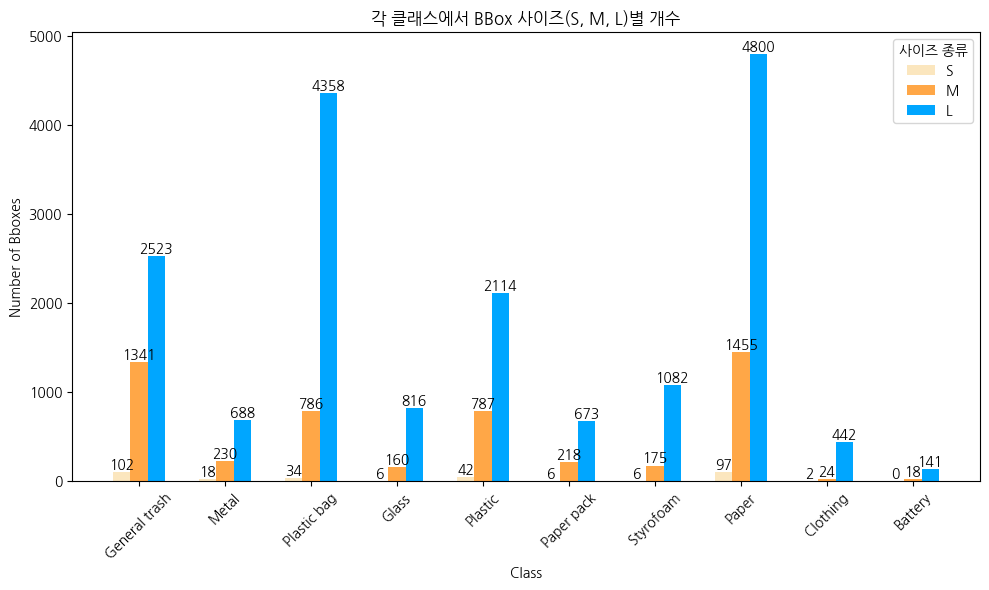

      Class Name  S (%)  M (%)  L (%)
0  General trash    2.6   33.8   63.6
1          Metal    1.9   24.6   73.5
2    Plastic bag    0.7   15.2   84.2
3          Glass    0.6   16.3   83.1
4        Plastic    1.4   26.7   71.8
5     Paper pack    0.7   24.3   75.0
6      Styrofoam    0.5   13.9   85.7
7          Paper    1.5   22.9   75.6
8       Clothing    0.4    5.1   94.4
9        Battery    0.0   11.3   88.7

      Class Name  S Count  M Count  L Count
0  General trash      102     1341     2523
1          Metal       18      230      688
2    Plastic bag       34      786     4358
3          Glass        6      160      816
4        Plastic       42      787     2114
5     Paper pack        6      218      673
6      Styrofoam        6      175     1082
7          Paper       97     1455     4800
8       Clothing        2       24      442
9        Battery        0       18      141


In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(len(classes))

bars1 = ax.bar(index, S_count, bar_width, label='S', color=(color3[0][0]/255, color3[0][1]/255, color3[0][2]/255))
bars2 = ax.bar([i + bar_width for i in index], M_count, bar_width, label='M', color=(color3[1][0]/255, color3[1][1]/255, color3[1][2]/255))
bars3 = ax.bar([i + 2 * bar_width for i in index], L_count, bar_width, label='L', color=(color3[2][0]/255, color3[2][1]/255, color3[2][2]/255))

ax.set_xlabel('Class')
ax.set_ylabel('Number of Bboxes')
ax.set_title('각 클래스에서 BBox 사이즈(S, M, L)별 개수')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(class_names, rotation=45)

ax.legend(title="사이즈 종류")

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(df_ratios)
print()
print(df)

### Validation 결과

#### BBox validation

In [26]:
log_stats_path = root + "/outputs/log_stats.txt"
fail_sml = parse_log_stats(log_stats_path)
print(fail_sml)

{3: [0, 31, 105, 1, 21, 121], 9: [0, 11, 79, 0, 5, 72], 0: [81, 524, 1072, 0, 104, 296], 7: [3, 96, 823, 1, 87, 335], 1: [0, 395, 973, 1, 114, 358], 2: [0, 128, 36, 4, 70, 113], 5: [1, 247, 330, 0, 53, 315], 4: [0, 9, 188, 0, 20, 83], 6: [0, 39, 91, 2, 26, 123], 8: [0, 0, 11, 0, 0, 30]}


In [27]:
class_names = [categories_id_name[cls] for cls in fail_sml.keys()]

# 맞은 개수 = 총 개수 - 실패한 개수
correct_s = df['S Count'] - [fail_sml[cls][0] for cls in fail_sml.keys()]
correct_m = df['M Count'] - [fail_sml[cls][1] for cls in fail_sml.keys()]
correct_l = df['L Count'] - [fail_sml[cls][2] for cls in fail_sml.keys()]

# Detection Failed와 Classification Failed 데이터 추출
detection_failed_s = [fail_sml[cls][0] for cls in fail_sml.keys()]
detection_failed_m = [fail_sml[cls][1] for cls in fail_sml.keys()]
detection_failed_l = [fail_sml[cls][2] for cls in fail_sml.keys()]

classification_failed_s = [fail_sml[cls][3] for cls in fail_sml.keys()]
classification_failed_m = [fail_sml[cls][4] for cls in fail_sml.keys()]
classification_failed_l = [fail_sml[cls][5] for cls in fail_sml.keys()]

# 비율 계산
total_s = df['S Count']
total_m = df['M Count']
total_l = df['L Count']

detection_failed_ratio_s = np.array(detection_failed_s) / total_s * 100
detection_failed_ratio_m = np.array(detection_failed_m) / total_m * 100
detection_failed_ratio_l = np.array(detection_failed_l) / total_l * 100

classification_failed_ratio_s = np.array(classification_failed_s) / total_s * 100
classification_failed_ratio_m = np.array(classification_failed_m) / total_m * 100
classification_failed_ratio_l = np.array(classification_failed_l) / total_l * 100

df_counts = pd.DataFrame({
    'Class Name': class_names,
    'D (S)': detection_failed_s,
    'D (M)': detection_failed_m,
    'D (L)': detection_failed_l,
    'C (S)': classification_failed_s,
    'C (M)': classification_failed_m,
    'C (L)': classification_failed_l
})

df_counts = df_counts.round(1)


#### 탐지 실패와 분류 실패 bbox 개수

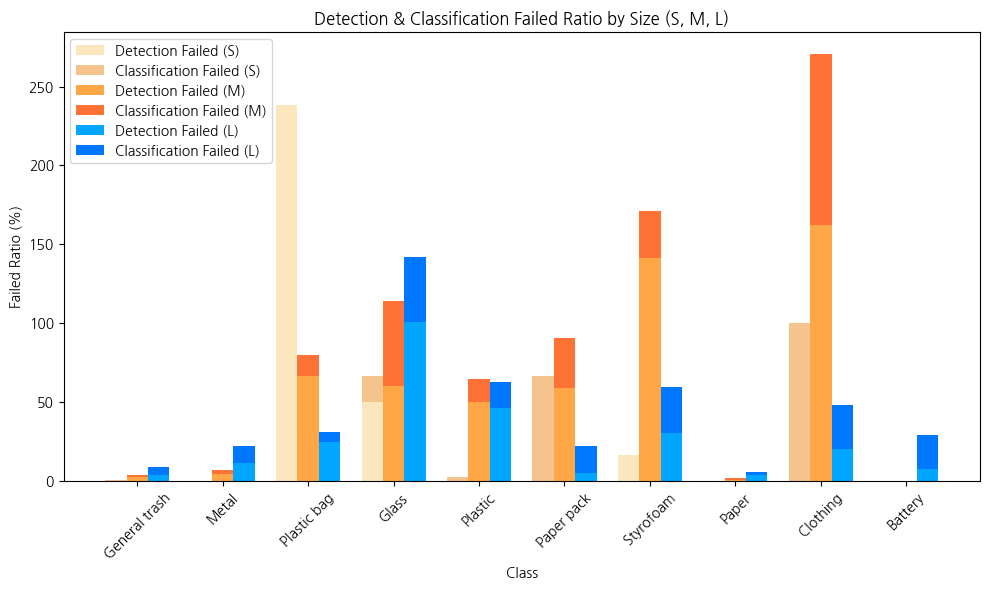


--- Detection & Classification Failed Counts ---
      Class Name  D (S)  D (M)  D (L)  C (S)  C (M)  C (L)
0          Metal      0     31    105      1     21    121
1       Clothing      0     11     79      0      5     72
2  General trash     81    524   1072      0    104    296
3    Plastic bag      3     96    823      1     87    335
4          Paper      0    395    973      1    114    358
5     Paper pack      0    128     36      4     70    113
6        Plastic      1    247    330      0     53    315
7          Glass      0      9    188      0     20     83
8      Styrofoam      0     39     91      2     26    123
9        Battery      0      0     11      0      0     30


In [28]:
categories = df['Class Name']
index = np.arange(len(categories))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# S 크기 막대 그래프 (누적)
ax.bar(index, detection_failed_ratio_s, bar_width, label='Detection Failed (S)', color=(color3[0][0]/255, color3[0][1]/255, color3[0][2]/255))
ax.bar(index, classification_failed_ratio_s, bar_width, bottom=detection_failed_ratio_s, label='Classification Failed (S)', color=(color3_1[0][0]/255, color3_1[0][1]/255, color3_1[0][2]/255))

# M 크기 막대 그래프 (누적)
ax.bar(index + bar_width, detection_failed_ratio_m, bar_width, label='Detection Failed (M)', color=(color3[1][0]/255, color3[1][1]/255, color3[1][2]/255))
ax.bar(index + bar_width, classification_failed_ratio_m, bar_width, bottom=detection_failed_ratio_m, label='Classification Failed (M)', color=(color3_1[1][0]/255, color3_1[1][1]/255, color3_1[1][2]/255))

# L 크기 막대 그래프 (누적)
ax.bar(index + 2 * bar_width, detection_failed_ratio_l, bar_width, label='Detection Failed (L)', color=(color3[2][0]/255, color3[2][1]/255, color3[2][2]/255))
ax.bar(index + 2 * bar_width, classification_failed_ratio_l, bar_width, bottom=detection_failed_ratio_l, label='Classification Failed (L)', color=(color3_1[2][0]/255, color3_1[2][1]/255, color3_1[2][2]/255))


ax.set_xlabel('Class')
ax.set_ylabel('Failed Ratio (%)')
ax.set_title('Detection & Classification Failed Ratio by Size (S, M, L)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(categories, rotation=45)

ax.legend()
plt.tight_layout()
plt.show()



print("\n--- Detection & Classification Failed Counts ---")
print(df_counts)

### 각 fold에서 class별 bbox 사이즈 S/M/L 개수 비교

#### Faster R-CNN에서 mapper없이 iter:8000 batch_size:4로 학습하였을 때 ap값(fold 순서 0 -> 4)

In [29]:
# Faster R-CNN에서 mapper없이 iter:8000 batch_size:4로 학습하였을 때 ap값(fold 순서 0 -> 4)
ap_data = {
    "General trash": [20.533, 18.404, 17.162, 17.191, 17.330],
    "Metal": [40.291, 35.142, 27.038, 38.836, 30.623],
    "Styrofoam": [35.501, 34.128, 31.924, 31.715, 29.341],
    "Clothing": [39.228, 28.945, 29.380, 28.945, 40.877],
    "Paper": [29.679, 29.242, 29.805, 28.404, 27.275],
    "Glass": [42.508, 34.319, 32.490, 41.668, 42.571],
    "Plastic bag": [52.525, 52.543, 53.290, 50.556, 54.407],
    "Paper pack": [38.887, 39.318, 34.027, 30.975, 38.657],
    "Plastic": [26.144, 26.541, 25.756, 26.789, 23.954],
    "Battery": [71.470, 36.025, 55.581, 52.738, 39.301]
}

#### 각 fold당 ap 그래프

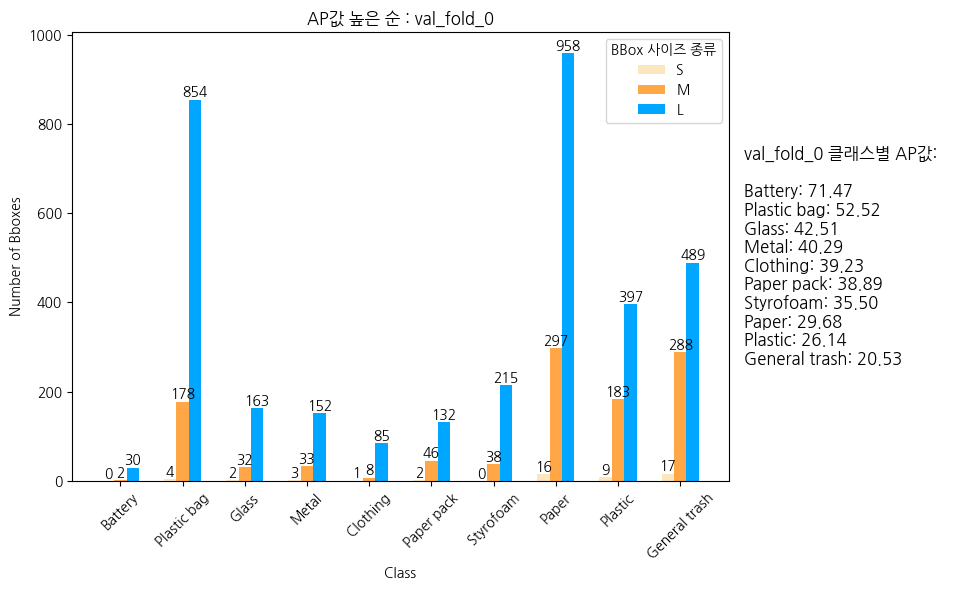

Large 박스 비율 순
      Class Name  S (%)  M (%)  L (%)
0        Battery    0.0    6.2   93.8
1       Clothing    1.1    8.5   90.4
2      Styrofoam    0.0   15.0   85.0
3          Glass    1.0   16.2   82.7
4    Plastic bag    0.4   17.2   82.4
5          Metal    1.6   17.6   80.9
6          Paper    1.3   23.4   75.4
7     Paper pack    1.1   25.6   73.3
8        Plastic    1.5   31.1   67.4
9  General trash    2.1   36.3   61.6


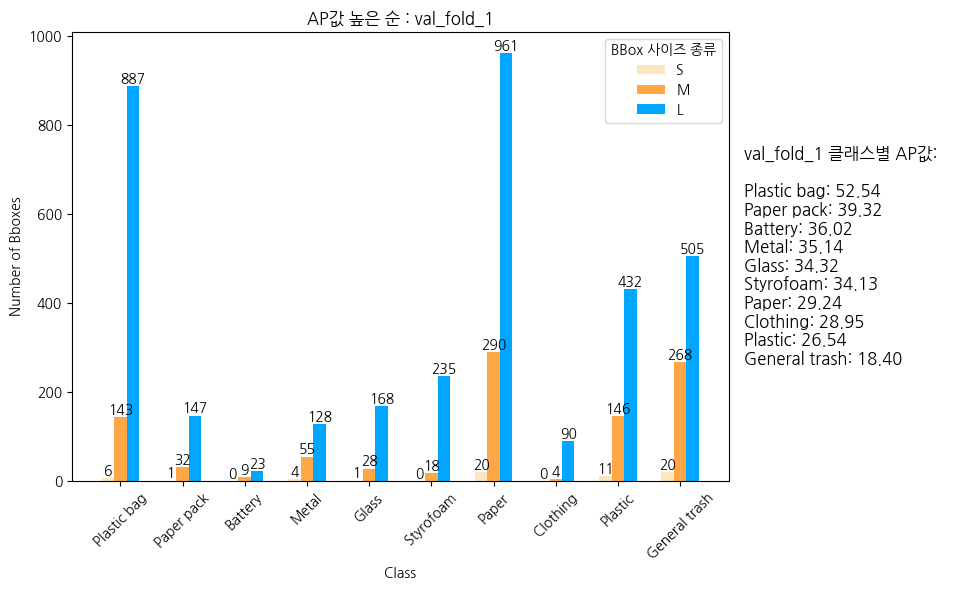

Large 박스 비율 순
      Class Name  S (%)  M (%)  L (%)
0       Clothing    0.0    4.3   95.7
1      Styrofoam    0.0    7.1   92.9
2    Plastic bag    0.6   13.8   85.6
3          Glass    0.5   14.2   85.3
4     Paper pack    0.6   17.8   81.7
5          Paper    1.6   22.8   75.6
6        Plastic    1.9   24.8   73.3
7        Battery    0.0   28.1   71.9
8          Metal    2.1   29.4   68.4
9  General trash    2.5   33.8   63.7


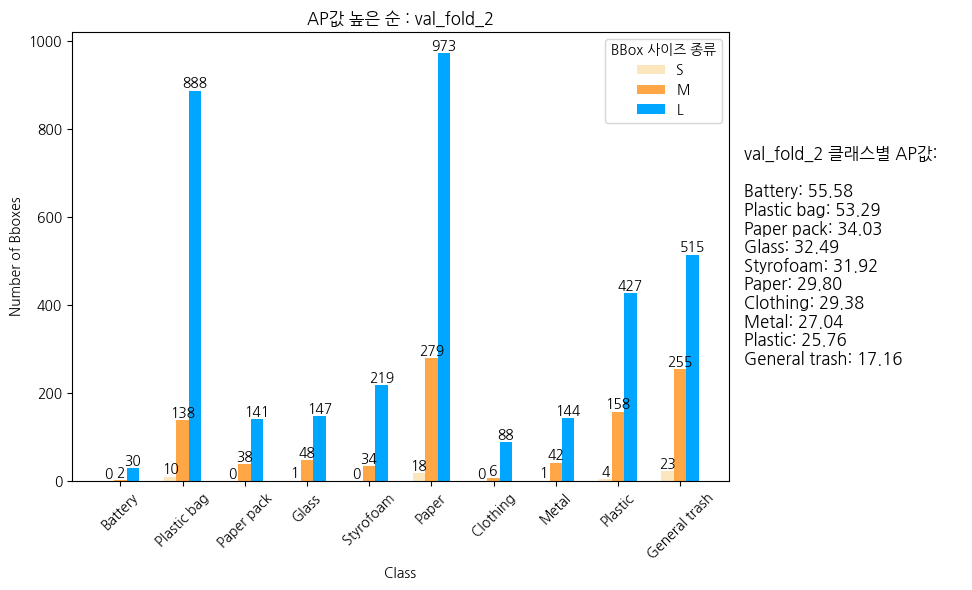

Large 박스 비율 순
      Class Name  S (%)  M (%)  L (%)
0        Battery    0.0    6.2   93.8
1       Clothing    0.0    6.4   93.6
2      Styrofoam    0.0   13.4   86.6
3    Plastic bag    1.0   13.3   85.7
4     Paper pack    0.0   21.2   78.8
5          Metal    0.5   22.5   77.0
6          Paper    1.4   22.0   76.6
7          Glass    0.5   24.5   75.0
8        Plastic    0.7   26.8   72.5
9  General trash    2.9   32.2   64.9


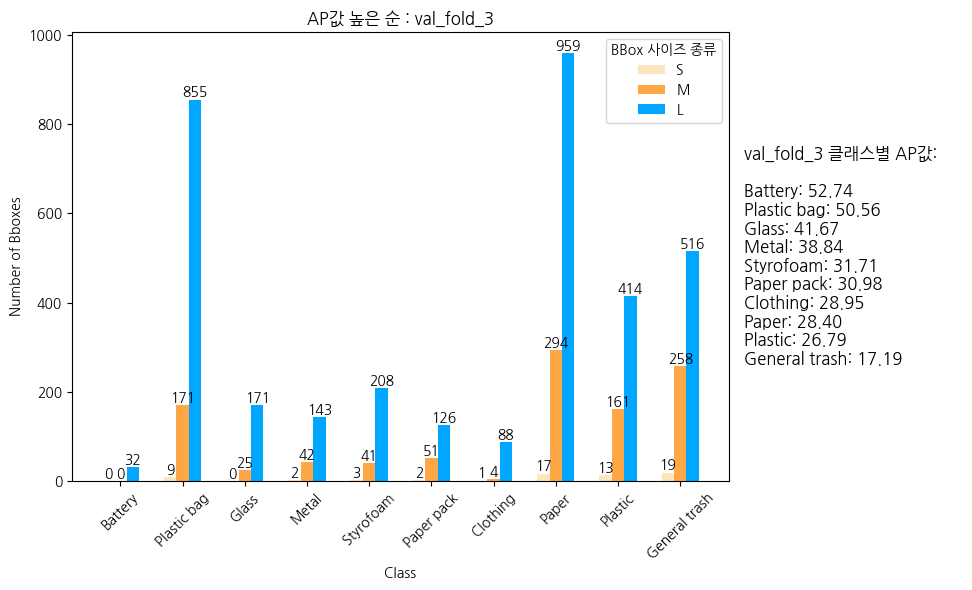

Large 박스 비율 순
      Class Name  S (%)  M (%)  L (%)
0        Battery    0.0    0.0  100.0
1       Clothing    1.1    4.3   94.6
2          Glass    0.0   12.8   87.2
3    Plastic bag    0.9   16.5   82.6
4      Styrofoam    1.2   16.3   82.5
5          Metal    1.1   22.5   76.5
6          Paper    1.3   23.1   75.5
7        Plastic    2.2   27.4   70.4
8     Paper pack    1.1   28.5   70.4
9  General trash    2.4   32.5   65.1


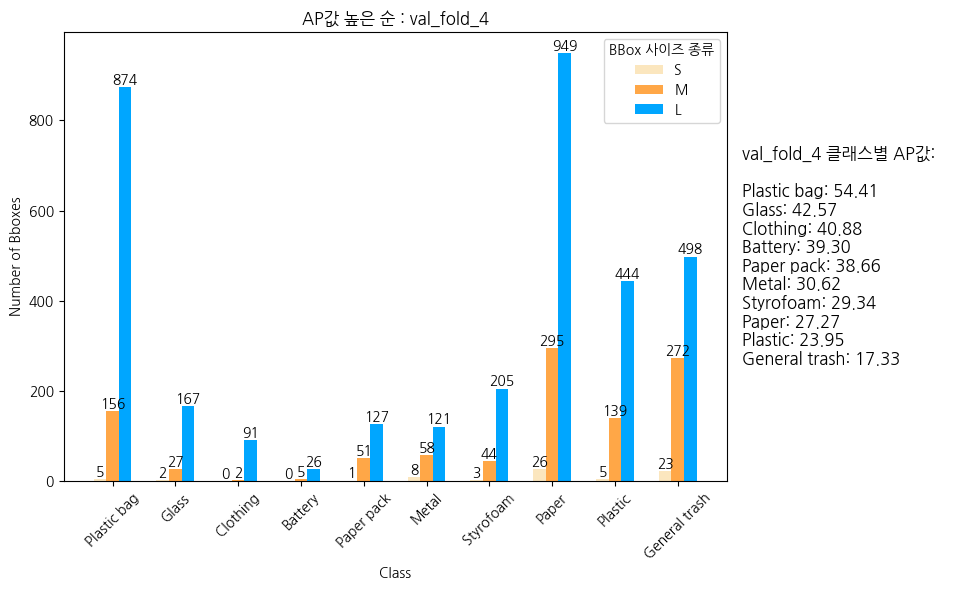

Large 박스 비율 순
      Class Name  S (%)  M (%)  L (%)
0       Clothing    0.0    2.2   97.8
1          Glass    1.0   13.8   85.2
2    Plastic bag    0.5   15.1   84.4
3        Battery    0.0   16.1   83.9
4      Styrofoam    1.2   17.5   81.3
5        Plastic    0.9   23.6   75.5
6          Paper    2.0   23.2   74.7
7     Paper pack    0.6   28.5   70.9
8          Metal    4.3   31.0   64.7
9  General trash    2.9   34.3   62.8


In [30]:
file_paths = [f'{root}/dataset/val_fold_{i}.json' for i in range(5)]

for i, file_path in enumerate(file_paths):
    if not os.path.exists(file_path):
        print(f"File {file_path} not found.")
        continue

    with open(file_path, 'r') as f:
        data = json.load(f)
    
    categories = data['categories']
    annotations = data['annotations']

    id_to_name = {category['id']: category['name'] for category in categories}
    name_to_id = {name: id_ for id_, name in id_to_name.items()}

    class_size_count = defaultdict(lambda: {'S': 0, 'M': 0, 'L': 0})

    for annotation in annotations:
        bbox = annotation['bbox']
        class_id = annotation['category_id']
        width, height = bbox[2], bbox[3]
        area = width * height

        if area <= small_threshold:
            class_size_count[class_id]['S'] += 1
        elif small_threshold < area <= medium_threshold:
            class_size_count[class_id]['M'] += 1
        else:
            class_size_count[class_id]['L'] += 1

    ap_classes = list(ap_data.keys())

    sorted_ap_classes = sorted(ap_classes, key=lambda cls: ap_data[cls][i], reverse=True)

    
    S_count = [class_size_count[name_to_id.get(cls, 0)]['S'] for cls in sorted_ap_classes]
    M_count = [class_size_count[name_to_id.get(cls, 0)]['M'] for cls in sorted_ap_classes]
    L_count = [class_size_count[name_to_id.get(cls, 0)]['L'] for cls in sorted_ap_classes]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 1]})  # 2개의 subplot, 2:1 비율

    bar_width = 0.2
    index = range(len(sorted_ap_classes))

    
    bars1 = ax1.bar(index, S_count, bar_width, label='S', color=(color3[0][0]/255, color3[0][1]/255, color3[0][2]/255))
    bars2 = ax1.bar([i + bar_width for i in index], M_count, bar_width, label='M', color=(color3[1][0]/255, color3[1][1]/255, color3[1][2]/255))
    bars3 = ax1.bar([i + 2 * bar_width for i in index], L_count, bar_width, label='L', color=(color3[2][0]/255, color3[2][1]/255, color3[2][2]/255))

    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Bboxes')
    ax1.set_title(f'AP값 높은 순 : val_fold_{i}')
    ax1.set_xticks([i + bar_width for i in index])
    ax1.set_xticklabels(sorted_ap_classes, rotation=45)

    ax1.legend(title="BBox 사이즈 종류")

    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

    
    ap_values = {cls: ap_data[cls][i] for cls in sorted_ap_classes}
    ap_text = "\n".join([f"{cls}: {ap_values[cls]:.2f}" for cls in sorted_ap_classes])

    ax2.axis('off')
    ax2.text(0, 0.5, f"val_fold_{i} 클래스별 AP값:\n\n{ap_text}", fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    class_names = [categories_id_name.get(cls, f'Class {cls}') for cls in classes]
    s_counts = [class_size_count[cls]['S'] for cls in classes]
    m_counts = [class_size_count[cls]['M'] for cls in classes]
    l_counts = [class_size_count[cls]['L'] for cls in classes]

    total_counts = [s + m + l for s, m, l in zip(s_counts, m_counts, l_counts)]


    s_ratios = [s / total if total > 0 else 0 for s, total in zip(s_counts, total_counts)]
    m_ratios = [m / total if total > 0 else 0 for m, total in zip(m_counts, total_counts)]
    l_ratios = [l / total if total > 0 else 0 for l, total in zip(l_counts, total_counts)]


    df_ratios = pd.DataFrame({
        'Class Name': class_names,
        'S (%)': [ratio * 100 for ratio in s_ratios],
        'M (%)': [ratio * 100 for ratio in m_ratios],
        'L (%)': [ratio * 100 for ratio in l_ratios]
    })

    df_ratios = df_ratios.round(1)
    df_ratios_sorted = df_ratios.sort_values(by='L (%)', ascending=False).reset_index(drop=True)

    print("Large 박스 비율 순")
    print(df_ratios_sorted)



- Large 박스가 많을수록 ap가 높고, small & medium 박스가 많을수록 ap가 낮았다
- small과 medium 박스가 많은 General trash, Plastic, Paper의 ap가 가장 낮았으며, 이에 대한 탐지 성능 개선이 필요해보인다
- 가장 높은 Large 박스 비율을 보이는 Clothing의 AP가 좋지 않은 것은 오분류 문제인지 정확한 확인이 필요하다
- 모든 fold에서 높은 점수를 보이는 Battery의 경우 작은 박스 비율이 가장 낮았다

### 바운딩 박스 생성 통계

#### S/M/L 크기별 맞은 개수와 실제 GT값 개수에 대한 비율

In [31]:
bbox_performance_path = root + '/outputs/bbox_performance.json'
val_analysis_path = root + '/outputs/val_analysis.txt'
ap_values = parse_val_analysis(val_analysis_path)

In [32]:
bbox_performance = load_bbox_performance(bbox_performance_path)
ap_values = parse_val_analysis(val_analysis_path)

data = fill_data_from_performance(bbox_performance, ap_values)

def calc_ratio(matched, actual):
    return round((matched / actual * 100), 1) if actual > 0 else "0.0"

In [33]:

df = pd.DataFrame(data)

df['S비율(%)'] = df.apply(lambda row: calc_ratio(row['S맞음'], row['S실제']), axis=1)
df['M비율(%)'] = df.apply(lambda row: calc_ratio(row['M맞음'], row['M실제']), axis=1)
df['L비율(%)'] = df.apply(lambda row: calc_ratio(row['L맞음'], row['L실제']), axis=1)

df['Class'] = df['Class'].map(categories_id_name)

df_ratios = df[['Class', 
                'S맞음', 'S전체', 'S실제', 'S비율(%)',
                'M맞음', 'M전체', 'M실제', 'M비율(%)',
                'L맞음', 'L전체', 'L실제', 'L비율(%)',
                'AP']]

df_ratios = df_ratios.round(2)



#### val_fold_3에 대한 validation 통계(AP값 고쳐야 함)

In [34]:
print(tabulate(df_ratios, headers='keys', tablefmt='pretty'))

+---+---------------+-------+-------+-------+----------+-------+-------+-------+----------+-------+-------+-------+----------+------+
|   |     Class     | S맞음 | S전체 | S실제 | S비율(%) | M맞음 | M전체 | M실제 | M비율(%) | L맞음 | L전체 | L실제 | L비율(%) |  AP  |
+---+---------------+-------+-------+-------+----------+-------+-------+-------+----------+-------+-------+-------+----------+------+
| 0 | General trash |   5   |  353  |  102  |   4.9    |  133  | 7277  | 1341  |   9.9    |  373  | 12556 | 2523  |   14.8   | 0.26 |
| 1 |  Paper pack   |   0   |  84   |   6   |   0.0    |  22   | 1889  |  218  |   10.1   |  115  | 2580  |  673  |   17.1   | 0.48 |
| 2 |  Plastic bag  |   2   |  695  |  34   |   5.9    |  67   | 11565 |  786  |   8.5    |  812  | 18822 | 4358  |   18.6   | 0.5  |
| 3 |   Styrofoam   |   0   |  151  |   6   |   0.0    |  11   | 2377  |  175  |   6.3    |  182  | 4986  | 1082  |   16.8   | 0.36 |
| 4 |   Clothing    |   0   |  27   |   2   |   0.0    |   2   |  434  |  24   |   8.3

##### 결과 분석
- 예측 바운딩 박스가 실제 GT 개수에 비해 과도하게 많이 생성되는 경향을 보였다
- battery의 경우 s, m 박스가 0개이고 l 박스 정답율이 100%이지만 ap가 0.68이다
    - 예를 들어 675번 이미지의 경우 정답을 맞추지 못한 경우가 대부분이기 때문에 정답율이 실제 100%라고 보기는 어려우며 실제로도, mAP값이 0.44이다
    - 또, gt와 예측이 일치하지만 Detection Failed로 처리된 부분은 IoU 기준이 미달되었다고 볼 수 있다
    - 그러나 gt 9개에 대하여 정답 처리된 높은 신뢰도 점수를 얻은 9개의 pred 박스가 존재하지만 False positive가 많이 포함되어 정밀도가 낮게 측정된 것으로 보인다
    - 이렇게 부정적인 영향을 미치는 박스를 제거해줄 필요가 있다
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/675_detection.jpg" alt="Sample Image 1" style="max-width: 20%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/ground_truth/0675_gt.jpg" alt="Sample Image 2" style="max-width: 20%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_bboxes/0675_correct_bboxes.jpg" alt="Sample Image 3" style="max-width: 20%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/images/스크린샷 2024-10-19 231750.png" alt="Sample Image 4" style="max-width: 15%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>

- 정답율이 100%가 넘는 박스가 있다(paper large, battery large, glass medium)
    - 바운딩 박스 크기가 실제 박스 크기 분포와 달라서 하나의 GT를 여러 개로 판단하거나, 중복된 박스가 여러 개 생겨서 여러 번 맞은 것으로 처리했을 가능성이 높다
    - paper medium의 경우 전체 예측 박스의 10% 이하가 정답인데 반해, 실제 GT에 대한 정답 비율이 63.6%이다
    - 691번의 경우 GT 13개에 대해서 12개가 정답처리 되었지만 mAP가 아주 낮고, 실제 중복 정답 처리된 박스를 확인할 수 있다
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/691_detection.jpg" alt="Sample Image 1" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/detection_failed/0691_detection_failed.jpg" alt="Sample Image 2" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/0691_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>
    - 2799번의 경우에도 GT 1개에 정답 처리된 박스가 2개이다
    - 이 경우에는 오탐지 오분류가 0개이지만 IoU 미달로 낮은 mAP를 보였다
    - 전체적으로 보면, 하나를 두 개로 나누어 탐지하여 False Positive로 간주된다
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/2799_detection.jpg" alt="Sample Image 1" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/2799_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>
- 17개의 GT 중 10개를 맞추고 mAP가 0.5가 넘은 679번 이미지는 탐지는 되었으나 분류를 잘못한 케이스이다
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/detection_failed/0679_detection_failed.jpg" alt="Sample Image 2" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/0679_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>
- 909
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/909_detection.jpg" alt="Sample Image 1" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/detection_failed/0909_detection_failed.jpg" alt="Sample Image 2" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/0909_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>
- 973
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/973_detection.jpg" alt="Sample Image 1" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/detection_failed/0973_detection_failed.jpg" alt="Sample Image 2" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/0973_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>
- 1249
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/1249_detection.jpg" alt="Sample Image 1" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/detection_failed/1249_detection_failed.jpg" alt="Sample Image 2" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/1249_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>
- 1281
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/1281_detection.jpg" alt="Sample Image 1" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/detection_failed/1281_detection_failed.jpg" alt="Sample Image 2" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/1281_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>
- 1841
<div style="text-align: center;">
    <img src="/data/ephemeral/home/outputs/visualized_images/bad_map/1841_detection.jpg" alt="Sample Image 1" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/detection_failed/1841_detection_failed.jpg" alt="Sample Image 2" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
    <img src="/data/ephemeral/home/outputs/correct_and_gt_bboxes/1841_correct_and_gt.jpg" alt="Sample Image 3" style="max-width: 30%; height: auto; display: inline-block; margin: 10px auto;"/>
</div>

##### 제안

- 중복을 줄이기 위해 NMS를 현재보다 조금 더 엄격하게 적용할 필요가 있다
- IoU값을 상향 조정하여 좀 더 엄격한 기준으로 맞은 개수를 처리할 필요가 있다(0.5 -> 0.6)
- 박스가 나뉘어 각각 정답처리 되면서 mAP가 낮아지는 케이스가 종종 확인되어 이 박스를 병합하는 등 후처리할 필요가 있다
